# Part 1 intuition behind elastic weight colsolidation

In the figure below, $\theta^{*}$ are the weights (ie parameters, synaptic strengths) learned by the neural network (NN) to solve old task A, shown as a vector in vector space. ie if this neural network as 100 total weights then this is a 2D representation of $\mathbb{R}^{100}$ space. The blue horizontal arrow shows an example of catastrophic forgetting, whereby $\theta^{*}$ moves out of the region that allows the NN to perform well at task A (grey), and into the center of a region that allows the NN to perform well at task B (cream). The downward green arrow is the update to $\theta^{*}$ regularized by L2 penalty $\alpha (\theta_{i} - \theta_{A , i}^{*})^{2}$ that causes it to move toward the cream region irrespective of the shape of the grey region. The desired update vector is the red arrow that moves the NN weights into a region capable of performing well at both tasks A and B. 

How Elastic Weight Cosolidation Changes Learning New Weights $\theta^{*}$
<p align="center">
<img src="https://raw.githubusercontent.com/clam004/intro_continual_learning/main/files/F1.large.jpg" height=500 width=500 >
</p>

EWC encourages movement of weights along the red path by modifying the loss function when re-training a NN that has already been trained to convergence using the loss function for task A, $L_{A}$, which has settled on weights $\theta_{A}$. When re-training the NN on task B using $L_{B}$, we add a term which penalizes changes to weights that are both far from $\theta_{A}$, ie $(\theta_{i} - \theta_{A , i}^{*})^{2}$, and also high in $F_{i}$ which encodes the shape of the grey region.

$$L \left(\right. \theta \left.\right) = L_{B} \left(\right. \theta \left.\right) + \underset{i}{\sum} \frac{\lambda}{2} F_{i} \left(\theta_{i} - \theta_{A , i}^{*}\right)^{2} $$

### But what is F_i? 

F_i is the diagonal of the Fisher information matrix. We want to use the diagonal components in Fisher Information Matrix to identify which parameters are more important to task A and apply higher weights to them (the direction of the short axis of grey oval). To learn B we should instead change those weights where F_i is small (long axis of grey oval).  

In the EWC paper:

"we approximate the posterior as a Gaussian distribution with mean given by the parameters θ∗A and a diagonal precision given by the diagonal of the Fisher information matrix F. F has three key properties (20): (i) It is equivalent to the second derivative of the loss near a minimum, (ii) it can be computed from first-order derivatives alone and is thus easy to calculate even for large models, and (iii) it is guaranteed to be positive semidefinite. Note that this approach is similar to expectation propagation where each subtask is seen as a factor of the posterior (21). where LB(θ) is the loss for task B only, λ sets how important the old task is compared with the new one, and i labels each parameter.

When moving to a third task, task C, EWC will try to keep the network parameters close to the learned parameters of both tasks A and B. This can be enforced either with two separate penalties or as one by noting that the sum of two quadratic penalties is itself a quadratic penalty."

### Lets learn what F is in the example

This article gives a very good explaination of F in the context of EWC: [Fisher Information Matrix by Yuan-Hong Liao](https://andrewliao11.github.io/blog/fisher-info-matrix/)

To compute F_i, we sample the data from task A once and calculate the empirical Fisher Information Matrix. 

$$
I_{\theta_\mathcal{A}^*} = \frac{1}{N}  \sum_{i=1}^{N} \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*) \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*)^T
$$

This is just to say that the above equation is how you calculate the below equation from the data. For each pair of parameters in $\theta$ ($\theta_i$ and $\theta_j$), the Fisher Information matrix at position ij is

$$
I(\theta)_{ij} = E\left[ \left( \frac{\partial}{\partial\theta_i}\log f(X;\theta) \right)\left( \frac{\partial}{\partial\theta_j}\log f(X;\theta) \right) \mid \theta\right]
$$

If this equation is hard to understand, then the code should make it clearer, dont worry, we will match parts of the code to the equation above so it becomes more tangible.

# Part 2 A look at the data and the task

### MNIST

The MNIST data set contains 70,000 images of handwritten digits and their corresponding labels. The images are 28x28 with pixel values from 0 to 255. The labels are the digits from 0 to 9. By default 60,000 of these images belong to a training set and 10,000 of these images belong to a test set.

### Fashion-MNIST

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

## Task

as you might guess, our goal is to train an NN that retains it's ability to perform well on MNIST after being retrained on only Fashion-MNIST

In [6]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

from contlearn.getdata import getMNIST, getFashionMNIST

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
# task A training and test set
train_loader_mnist, test_loader_mnist = getMNIST(batch_size=32)

# task B training and test set
train_loader_fashion, test_loader_fashion = getFashionMNIST(batch_size=32)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



tensor(6)
torch.Size([28, 28])


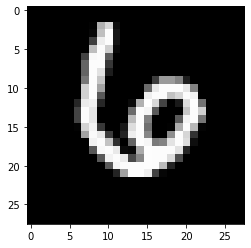

In [8]:
input_image, target_label = next(iter(train_loader_mnist))

print(target_label[0])
print(input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255)

plt.imshow(img)

Shirt
torch.Size([28, 28])


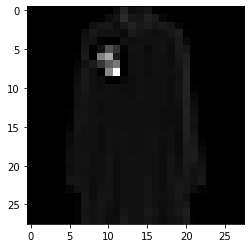

In [9]:
input_image, target_label = next(iter(train_loader_fashion))

fashion_key = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

print(fashion_key[int(target_label[0].detach().cpu().numpy())])
print(input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255)

plt.imshow(img)

# Part 3 Baseline results

first we train on MNIST and the we will observe the drop in performance once we retrain on Fashion-MNIST, WITHOUT Elastic Weight Consolidation

In [10]:
import math
import random

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from tqdm.notebook import tqdm

from contlearn.getmodels import MLP
from contlearn.gettrainer import one_epoch_baseline, test, var2device

%load_ext autoreload
%autoreload 2
%matplotlib inline

print('you are using PyTorch version ',torch.__version__)

if torch.cuda.is_available():
    use_cuda = True
    print("you have", torch.cuda.device_count(), "GPUs")
    device = torch.device("cuda:0")
    print(device)
else:
    use_cuda = False
    print('no GPUs detected')
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
you are using PyTorch version  1.13.0+cu116
no GPUs detected


In [12]:
# initialize a new model

model = MLP(hidden_size=256)

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
# push an image through it

input_image, target_label = next(iter(train_loader_fashion))

input_image = var2device(input_image).squeeze(1)

print(input_image.shape)

output = model(input_image)

print(output.shape)

torch.Size([32, 28, 28])
torch.Size([32, 10])


In [13]:
def baseline_training(
    model, 
    epochs, 
    train_loader,
    test_loader,
    test2_loader = None,
    use_cuda=True, 
):
    
    """
    This function saves the training curve data consisting
    training set loss and validation set accuracy over the
    course of the epochs of training.
    
    I set this up such that if you provide 2 test sets,you
    can watch the test accuracy change together during training
    on train_loder
    """
    
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
        
    train_loss, val_acc, val2_acc = [], [], []
    
    for epoch in tqdm(range(epochs)):

        epoch_loss = one_epoch_baseline(model,train_loader)
        train_loss.append(epoch_loss)
        
        acc = test(model,test_loader)
        val_acc.append(acc.detach().cpu().numpy())
        
        if test2_loader is not None:
            acc2 = test(model,test2_loader)
            val2_acc.append(acc2.detach().cpu().numpy())
            
    return train_loss, val_acc, val2_acc, model 

In [15]:
# set seeds for reproducibility and train the model using the training loop called
# baseline_training

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc,  model = baseline_training(
    model,
    epochs = 25,
    train_loader = train_loader_mnist,
    test_loader = test_loader_mnist,
)

# save the trained model
model = model.cpu()
torch.save(model, "files/basemodel.pth")

  0%|          | 0/25 [00:00<?, ?it/s]

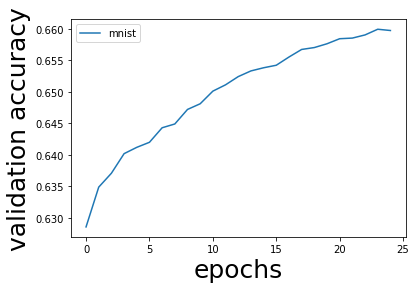

In [16]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
plt.plot(val_acc, label='mnist')
plt.legend()
plt.show()

### learning curve
you should get something like this where the accuracy starts to plateau at around 75% for this simple feed forward model

<img src="https://raw.githubusercontent.com/clam004/intro_continual_learning/main/files/baseline_mnist.png">

In [17]:
# you can use this to load the model instead of training it from scratch like above 

model = torch.load("files/basemodel.pth")

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
# tensor(0.8238, device='cuda:0') means that the test set accuracy was 82.4%
# compared to a baseline accuracy of 10% if the model is choosing randomly
print('mnist accuracy', test(model,test_loader_mnist))
print('fashion accuracy', test(model,test_loader_fashion))

mnist accuracy tensor(0.6597)
fashion accuracy tensor(0.1205)


### Catastrophic Forgetting

This is one of the main problems we are trying to solve in the continual learning, aka lifelong learning, aka sequential learning, research field. As you can see, learning Fashion MNIST also degrades performance on original MNIST. In part this is because some of the useful parameters, aka weights, used for original MNIST, are overwritten or updated past what is useful for original MNIST in order to become useful for Fashion MNIST

We expect something like this in which the fashion accuracy increases from it's random performance at around 10% to almost 40% and the mnist test accuracy drops to below 30% from a previous performance of around 80%
<img src="https://raw.githubusercontent.com/clam004/intro_continual_learning/main/files/catastrophic_forgetting.png">



In [18]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc,  model = baseline_training(
    model,
    epochs = 25,
    train_loader = train_loader_fashion,
    test_loader = test_loader_fashion,
    test2_loader = test_loader_mnist,
)

  0%|          | 0/25 [00:00<?, ?it/s]

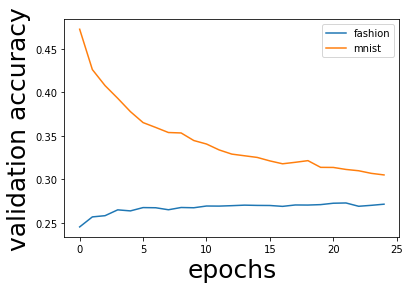

In [19]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
plt.plot(val_acc, label='fashion')
plt.plot(val2_acc, label='mnist')
plt.legend()
plt.show()

# Part 4 Elastic Weight Consolidation

now that we have implemented the control group, lets implement the experimental group

instead of revisiting every old MNIST example to build our Fisher Information Matrix, we will visit num_samples of them to form a approximate of the matrix

please read the comments in the EWC class, which explains each step of the math needed
to calculate the EWC loss function, dont worry if it doesnt make sense, we will then go through it step by step

After gathering your examples of task A in the cell below, mnist, run the below cells from the second cell all the way to 

#### sum the squares of the gradients

comparing the norm of the precision _matrices when you use a pretrained model and using a randomly initialized model 

In [20]:
# instead of revisiting every old MNIST example to build our Fisher Information Matrix
# use num_samples of them to calculate a approximate of the matrix

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

num_batches = 16

old_tasks = []

for sample in range(num_batches):
    input_batch, target_batch = next(iter(train_loader_mnist))
    for image in input_batch:
        old_tasks.append(image)
    
print("num_samples", len(old_tasks))

num_samples 512


In [21]:
from copy import deepcopy

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import torch.utils.data

from contlearn.getmodels import MLP
from contlearn.gettrainer import var2device

%load_ext autoreload
%autoreload 2
%matplotlib inline


# Uncomment one of the two below lines of code that instantiates a model
### birth a new randomly initiated model ###

# model = MLP(hidden_size=256)

### load a model previously trained on one task, task A ###

model = torch.load("files/basemodel.pth")

#####


if torch.cuda.is_available() and use_cuda:
    model.cuda()    
# tensor(0.8238, device='cuda:0') means that the test set accuracy was 82.4%
# compared to a baseline accuracy of 10% if the model is choosing randomly
acc = test(model,test_loader_mnist)
print("accuracy on mnist test set", acc.item())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
accuracy on mnist test set 0.6596999764442444


In [22]:
class EWC(object):
    
    """
    Class to calculate the Fisher Information Matrix
    used in the Elastic Weight Consolidation portion
    of the loss function
    """
    
    def __init__(self, model: nn.Module, dataset: list):

        self.model = model #pretrained model
        self.dataset = dataset #samples from the old task or tasks
        
        # n is the string name of the parameter matrix p, aka theta, aka weights
        # in self.params we reference all of those weights that are open to
        # being updated by the gradient
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        
        # make a copy of the old weights, ie theta_A,star, ie 𝜃∗A, in the loss equation
        # we need this to calculate (𝜃 - 𝜃∗A)^2 because self.params will be changing 
        # upon every backward pass and parameter update by the optimizer
        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = var2device(p.data)
        
        # calculate the fisher information matrix 
        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        
        # save a copy of the zero'd out version of
        # each layer's parameters of the same shape
        # to precision_matrices[n]
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = var2device(p.data)

        # we need the model to calculate the gradient but
        # we have no intention in this step to actually update the model
        # that will have to wait for the combining of this EWC loss term
        # with the new task's loss term
        self.model.eval()
        for input in self.dataset:
            self.model.zero_grad()
            # remove channel dim, these are greyscale, not color rgb images
            # bs,1,h,w -> bs,h,w
            input = input.squeeze(1)
            input = var2device(input)
            output = self.model(input).view(1, -1)
            label = output.max(1)[1].view(-1)
            # calculate loss and backprop
            loss = F.nll_loss(F.log_softmax(output, dim=1), label)
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss
    
# place the model pretrained on mnist, but not fashion-mnist, along with some mnist examples
# into the Elastic Weight Consolidation object to perform EWC related tasks like calculating the
# Fisher Matrix
ewc = EWC(model, old_tasks)

### Empirical Estimate of the Fisher Information Matrix

Lets work through the _diag_fisher() method that calculates the fisher matrix, 


together, step by step

as a reminder here is the equation for the fisher matrix one more time

$$
I_{\theta_\mathcal{A}^*} = \frac{1}{N}  \sum_{i=1}^{N} \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*) \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*)^T
$$

To my understanding, the equation is saying, sum N of these matrices on top of each other such that the resultant matrix is the same shape of the individual matrices. The gradient term $\nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*)$ is a vector and the expression $ \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*) \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*)^T$ represents the [outer product](https://en.wikipedia.org/wiki/Outer_product) of these two vectors to produce a matrix where the elements of that matrix we are interested in is the diagonal $F_{ii}$. ie we are interested in $I_{ii}$, not $I_{ij}$. 

note: does this mean that in addition to penalizing moving $\theta_i$ when $F_{ii}$ is high,  we could also penalize moving both $\theta_i$ and $\theta_j$ together when $F_{ij}$ is high?

### The Fisher Information Matrix is w.r.t the log probability of the NN prediction p(y|x,theta), rather than w.r.t the log likelihood of the data p(x|theta)

notice that the term grad log p(D|theta)

$$\nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*)$$

looks alot like the formula for the gradient of the loss function with respect to the parameters.

Thats because for the purposes of EWC, it is!

from the [Overcoming catastrophic forgetting in neural networks paper](https://www.pnas.org/content/114/13/3521):

"""
Note that the log probability of the data given the parameters logp(D|θ) is simply the negative of the loss function for the problem at hand −L(θ). 
"""

The key mental leap we need to make is that in our machine learning model, p(D|θ) is the probability of the target label given the parameters rather than the p(X|θ) we are used to seeing that represents the likelihood of observing X given θ. 

Had the neural netword ended in a softmax layer the term $p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*)$ would be the softmax output, but in the code this is combined with the log using the F.log_softmax function. 

$ log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*)$ is the log likelihood. In the code below this is:

```
F.log_softmax(output, dim=1)
```

from [the pytorch docs](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss)

"""
Obtaining log-probabilities in a neural network is easily achieved by adding a LogSoftmax layer in the last layer of your network. You may use CrossEntropyLoss instead, if you prefer not to add an extra layer.
"""

Meaning that the full line of code:

```
F.nll_loss(F.log_softmax(output, dim=1), label)
```

is essentially the cross entropy loss

In [23]:
precision_matrices = {}
for n, p in deepcopy(ewc.params).items():
    
    print("name of this layer's weights:", n)
    p.data.zero_()
    precision_matrices[n] = var2device(p.data)
    print("shape of this matrix W", precision_matrices[n].shape)
    #print(precision_matrices[n])
    print("norm of the matrix",torch.norm(precision_matrices[n]).item())
    break

name of this layer's weights: fc1.weight
shape of this matrix W torch.Size([256, 784])
norm of the matrix 0.0


#### the code above
As a reminder, your input shape x is (batch_size, 784) becasue 28*28 = 784. 

The matrix W of this first linear, aka affine, aka fully connect layer, is
(256, 784) because xW^T = a of shape (batch_size, 256) which is the shape of the first layer's activations

#### the code below
we pass just one image through our model, and examine the tensors being created
as they are applied to just the first layer of parameters ofcourse the
real thing accumulates this update through all the samples and all the layers

input.shape torch.Size([1, 28, 28])
[0.0, 0.0, 1.7875112, 0.0, 1.6482642, 0.0, 6.588932, 0.0, 0.0, 0.0]
predicted number tensor([6])
loss 0.024689100682735443


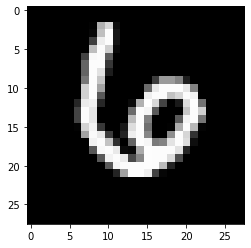

In [24]:
ewc.model.eval()
for input in ewc.dataset:
    ewc.model.zero_grad()
    # no need for the channel dim, these are greyscale, not color rgb images
    # bs,1,h,w -> bs,h,w
    input = input.squeeze(1)
    input = var2device(input)
    output = ewc.model(input).view(1, -1)
    label = output.max(1)[1].view(-1)
    loss = F.nll_loss(F.log_softmax(output, dim=1), label)
    loss.backward()    
    break

print("input.shape", input.shape)
img = Image.fromarray(input[0].detach().cpu().numpy()*255)
plt.imshow(img)

print(list(output.detach().cpu().numpy()[0]))
print("predicted number",label)
print("loss",loss.item())

### sum the squares of the gradients

the cell below is the last one you should run when comparing the [norm](https://pytorch.org/docs/stable/generated/torch.norm.html) of the matrix between when the model is pretrained or not.

noticed that when you ran the above steps with a pretrained model, the norm is larger than when run with a randomly initialized model, why is this? 

In [25]:
for n, p in ewc.params.items():
    print("name of this layer's weights:", n)
    print("shape of p.grad.data", p.grad.data.shape)
    print("shape of p.grad.data ** 2", (p.grad.data ** 2).shape)
    precision_matrices[n].data += p.grad.data ** 2 / len(ewc.dataset)
    #print(precision_matrices[n])
    print("norm of the matrix",torch.norm(precision_matrices[n]).item())
    break

name of this layer's weights: fc1.weight
shape of p.grad.data torch.Size([256, 784])
shape of p.grad.data ** 2 torch.Size([256, 784])
norm of the matrix 1.293625700782286e-05


### The Math in the Code

One clarification that I think needs to be made that was brought to my attention on [Reddit](https://www.reddit.com/r/MachineLearning/comments/t2riby/p_i_made_the_kind_of_tutorial_i_wish_someone_had/?utm_source=share&utm_medium=web2x&context=3). The equation for the empirical fisher below suggests we are calculating the full Fisher Matrix:

$$
I_{\theta_\mathcal{A}^*} = \frac{1}{N}  \sum_{i=1}^{N} \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*) \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*)^T
$$

But in the code we are not, this line is where the diagonal terms are calculated

```
p.grad.data ** 2
```

the above line of code corresponds only to the diagonal component of the matrix $I_{\theta_\mathcal{A}^*}$ above.

Notice `p.grad.data ** 2` is the same shape as the W for each layer, thats becasue `** 2` is an element-wise operation where we square every element. which is essentially the gradient of the loss function w.r.t. just one parameter, aka weight, multiplied by itself. If we took all the layer's `p.grad.data ** 2`'s and flattened them out into a very long vector, then that would be the just diagonal of the fisher matrix we see in the above equation. So we have only calculated the F_ii terms of the matrix and none of the F_ij terms. 

note: the diagonal therefore must all be positive valued

The fisher diagonals are summed over all the N examples and divided by N, aka we average them to get the mean, aka the expectation, which is why in the actual EWS class, the code is written

```
+= p.grad.data ** 2 / len(self.dataset)
```

and placed in the inner loop of:

```
for input in self.dataset:
```

After the code accumulates over all N examples, it completes the rest of the equation:

$$
\frac{1}{N}  \sum_{i=1}^{N} \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*) \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*)^T
$$


### using the F_i in the overall loss function

this line of code in the `penalty()` method of the EWS class

```
_loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
```

corresponds to this formula

$$ F_{i} \left(\theta_{i} - \theta_{A , i}^{*}\right)^{2} $$

where `self._precision_matrices[n]` = $ F_{i}$ and 
`(p - self._means[n]) ** 2` = $\left(\theta_{i} - \theta_{A , i}^{*}\right)^{2} $

this is then summed over all parameters `loss += _loss.sum()`
and done for each layer, which is why the `penaly()` method places this line of code in the inner loop of `for n, p in model.named_parameters():`

later in the code for EWC training, this has to be added to the loss for task B `F.cross_entropy(output, target)` and scaled by 

$\lambda$ = importance, for the full line of code:

`loss = F.cross_entropy(output, target) + importance * ewc.penalty(model)`

which is the equivalent of our EWC loss function

$$
L \left(\right. \theta \left.\right) = L_{B} \left(\right. \theta \left.\right) + \underset{i}{\sum} \frac{\lambda}{2} F_{i} \left(\theta_{i} - \theta_{A , i}^{*}\right)^{2} $$

### Explaination

For the full proof read [Fisher Information Matrix by Agustinus Kristiadi](https://agustinus.kristia.de/techblog/2018/03/11/fisher-information/) or [Fisher Information Matrix by Yuan-Hong Liao](https://andrewliao11.github.io/blog/fisher-info-matrix/). 

The end result of the proof is that "The Fisher is the negative expectation of the Hessian of the log-likelihood"

The Hessian is a square matrix of second-order partial derivatives of a scalar-valued function, or scalar field. It describes the local curvature of a function of many variables. So the diagonal of the Hessian is the 2nd derivative of the loss (negative log likelihood) with respect to the parameters.  Imagine if you only had 2 parameters, the Fisher Information over a patch of values for $\theta_i$ adn $\theta_j$ might look like this:

Hypothetical F_ij Surface, ignore the vertical axis label for now
<p align="center">
<img src="https://raw.githubusercontent.com/clam004/chat-transformer/main/saved/images/LossTopology.png" height=800 width=800 >
</p>

The warmer areas (more red) are the areas of higher curvature, the areas of higher curvature are the areas of local minima and maxima. If you turn the above figure upside down, this would look just like the topological manifold, aka surface, of the loss function, And what is gradient descent trying to do? it is trying to find a local minima on this loss surface, aka a local maxima on the fisher information surface. 

In intuitive terms, both the Hessian and Fisher Matrix describe how sharp, ie curved, each point in $\theta$ space is, with respect to the loss.

But wait a minute, cant we have a valley with a very flat and wide floor? yes we can, and it very well might be that some of our parameters have settled into such a region while training on task A. However, if that is the case, then while $\theta$ is in the center of such a region, it can move in various directions and still contribute to good performance on task A, which means we should not penalize changes in this region until $\theta$ reaches the edge of such a region, in which case, the Fisher information should start to increase. 

Basically the Fisher Matrix is the negative of this matrix below, where you replace f with log[p(x|theta)] and replace x with theta
<p align="center">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/d2b255c49df2a6e084b9196ab71a68872a739ead" height=400 width=400 >
</p>

*The $F_i$ is higher for those $\theta_i$ that are already optimized into a narrow region and thus if changed, would cause an increase in the loss for task A, thereby reducing the performance on task A described by that loss. More of these "important and just right" parameters will exist for trained models and thus the norm on the fisher diagonals will be higher. For models not yet trained on task A, there are fewer parameters that have been optimized to help solve task A, therefore fewer parameters that when changed will have a significant effect on the loss for task A*

In [26]:
# since the parameters have not changed yet, we expect (𝜃 - 𝜃∗)2 to be zero throughout
ewc.penalty(model)

tensor(0., grad_fn=<AddBackward0>)

### EWC Training

Load a model pretrained on MNIST, then train it on Fashion-MNIST while observing the new training's effect on MNIST performance

In [27]:
# verify that the model you are about to retrain is indeed pretrained
acc = test(model,test_loader_mnist)
print("accuracy on mnist test set", acc.item())

accuracy on mnist test set 0.6596999764442444


In [28]:
def one_epoch_ewc(
    ewc: EWC, 
    importance: float,
    model: nn.Module, 
    data_loader: torch.utils.data.DataLoader, 
    lr = 1e-3,
):
    model.train()
    epoch_loss = 0
    optimizer = optim.SGD(params=model.parameters(), lr=lr)
    for input, target in data_loader:
        # no need for the channel dim
        # bs,1,h,w -> bs,h,w
        input = input.squeeze(1) 
        input, target = var2device(input), var2device(target)
        optimizer.zero_grad()
        output = model(input)
        loss = F.cross_entropy(output, target) + importance * ewc.penalty(model)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)

def ewc_training(
    ewc,
    importance,
    model, 
    epochs, 
    train_loader,
    test_loader,
    test2_loader = None,
    use_cuda=True, 
):
    
    """
    This function saves the training curve data consisting
    training set loss and validation set accuracy over the
    course of the epochs of training.
    
    I set this up such that if you provide 2 test sets,you
    can watch the test accuracy change together during training
    on train_loder
    """
    
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
        
    train_loss, val_acc, val2_acc = [], [], []
    
    for epoch in tqdm(range(epochs)):

        epoch_loss = one_epoch_ewc(ewc,importance, model,train_loader)
        train_loss.append(epoch_loss)
        
        acc = test(model,test_loader)
        val_acc.append(acc.detach().cpu().numpy())
        
        if test2_loader is not None:
            acc2 = test(model,test2_loader)
            val2_acc.append(acc2.detach().cpu().numpy())
            
    return train_loss, val_acc, val2_acc, model 

In [29]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc, model = ewc_training(
    ewc = ewc,
    importance = 1000,
    model = model,
    epochs = 25,
    train_loader = train_loader_fashion,
    test_loader = test_loader_fashion,
    test2_loader = test_loader_mnist,
)

  0%|          | 0/25 [00:00<?, ?it/s]

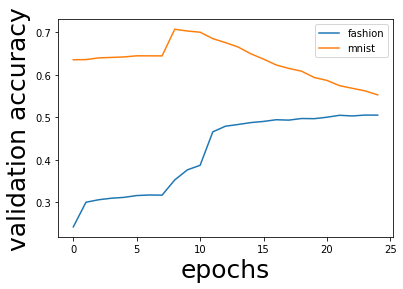

In [30]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
plt.plot(val_acc, label='fashion')
plt.plot(val2_acc, label='mnist')
plt.legend()
plt.show()

In [31]:
# save the trained model
model = model.cpu()
torch.save(model, "files/ewcmodel.pth")

### Conclusion

We expect a result like this, where instead of the mnist accuracy dropping to below 30%, it degrades by a far lesser amount, it is still above 70%, from around 80% at the end of mnist training. meanwhile, learning of the fashion-mnist dataset still proceed forward, rising above 40% from a baseline below 10%. The performances here are modest, but that is not the point, im sure with architectures specialized for images like convolutional layers or vision transformers you can get the final accuracy much higher, the point here is that we were able to preserve previously learned capabilities of our NN

<p align="center">
<img src="https://raw.githubusercontent.com/clam004/intro_continual_learning/main/files/ewc_training.png" height=400 width=400 >
</p>